---
#**Pregunta a Abordar**
---
*¿Cuál será la demanda futura de bicicletas?*

---
#**Configuración del ambiente**
---

In [17]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.metrics import mean_absolute_error
pd.set_option('display.max_columns', None)

---
#**Data wrangling**
---

In [2]:
df = pd.read_csv(
    "/content/drive/MyDrive/CitiBanamex Curso/SeoulBikeData.csv",
    encoding = "ISO-8859-15"
)
df.rename(columns = {
    "Date": "date",
    "Rented Bike Count": "rented",
    "Hour": "hour",
    "Temperature(°C)": "temperature",
    "Humidity(%)": "humidity",
    "Wind speed (m/s)": "wind",
    "Visibility (10m)": "visibility",
    "Dew point temperature(°C)": "dewPoint",
    "Solar Radiation (MJ/m2)": "radiation",
    "Rainfall(mm)": "rain",
    "Snowfall (cm)": "snow",
    "Seasons": "seasons",
    "Holiday": "holiday",
    "Functioning Day": "open"
}, inplace = True)
df["date"] = pd.to_datetime(df["date"], format = "%d/%m/%Y") + pd.to_timedelta(df["hour"], unit = "h")
df["dW"] = df["date"].dt.weekday
df["dD"] = df["date"].dt.day
df["dM"] = df["date"].dt.month
df["seasons"] = df["seasons"].str[:3].str.lower()
df["holiday"] = (df["holiday"] == "No Holiday").astype(int)
df["open"] = (df["open"] == "Yes").astype(int)
df.sort_values(["date", "hour"], ascending = False, ignore_index = True, inplace = True)
df.head()
df = pd.get_dummies(
    df,
    columns = ["seasons"],
    prefix = ["s"],
    dtype = int
)
df.head()

,date,rented,hour,temperature,humidity,wind,visibility,dewPoint,radiation,rain,snow,holiday,open,dW,dD,dM,s_aut,s_spr,s_sum,s_win
0,2018-11-30 23:00:00,584,23,1.9,43,1.3,1909,-9.3,0.0,0.0,0.0,1,1,4,30,11,1,0,0,0
1,2018-11-30 22:00:00,712,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,1,1,4,30,11,1,0,0,0
2,2018-11-30 21:00:00,694,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,1,1,4,30,11,1,0,0,0
3,2018-11-30 20:00:00,764,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,1,1,4,30,11,1,0,0,0
4,2018-11-30 19:00:00,1003,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,1,1,4,30,11,1,0,0,0


---
#**Data Types**
---

In [3]:
df.dtypes

date           datetime64[ns]
rented                  int64
hour                    int64
temperature           float64
humidity                int64
wind                  float64
visibility              int64
dewPoint              float64
radiation             float64
rain                  float64
snow                  float64
holiday                 int64
open                    int64
dW                      int32
dD                      int32
dM                      int32
s_aut                   int64
s_spr                   int64
s_sum                   int64
s_win                   int64
dtype: object

---
#**Exploratory Data Analysis**
---

In [4]:
df.describe()

,date,rented,hour,temperature,humidity,wind,visibility,dewPoint,radiation,rain,snow,holiday,open,dW,dD,dM,s_aut,s_spr,s_sum,s_win
count,8760,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,2018-06-01 11:30:00,704.602055,11.500000,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068,0.950685,0.966324,3.002740,15.720548,6.526027,0.249315,0.252055,0.252055,0.246575
min,2017-12-01 00:00:00,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2018-03-02 05:45:00,191.000000,5.750000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,8.000000,4.000000,0.000000,0.000000,0.000000,0.000000
50%,2018-06-01 11:30:00,504.500000,11.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000,1.000000,1.000000,3.000000,16.000000,7.000000,0.000000,0.000000,0.000000,0.000000
75%,2018-08-31 17:15:00,1065.250000,17.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000,1.000000,1.000000,5.000000,23.000000,10.000000,0.000000,1.000000,1.000000,0.000000
max,2018-11-30 23:00:00,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000,1.000000,1.000000,6.000000,31.000000,12.000000,1.000000,1.000000,1.000000,1.000000
std,NaN,644.997468,6.922582,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746,0.216537,0.180404,1.998056,8.796749,3.448048,0.432641,0.434217,0.434217,0.431042


---
#**Correlation Coefficient**
---

In [5]:
correlation_threshold = 0.1 # >= 10%
df_c = df.corr()["rented"].abs().sort_values(ascending = False)
df_c = df_c[df_c.index != "rented"]
df_c = df_c[df_c >= correlation_threshold]
df_c

temperature    0.538558
s_win          0.424925
hour           0.410257
dewPoint       0.379788
date           0.341894
s_sum          0.296549
radiation      0.261837
open           0.203943
humidity       0.199780
visibility     0.199280
snow           0.141804
dM             0.133514
rain           0.123074
wind           0.121108
s_aut          0.102753
Name: rented, dtype: float64

---
#**Train-Test Split \% Time Window**
---

In [6]:
train_window = 0.95 #95%
rows_train = int(df.shape[0] * train_window)
rows_test  = df.shape[0] - rows_train
df_train = df.iloc[-rows_train:].copy()
df_test  = df.iloc[ :rows_test ].copy()
print(f'''
Training Time Window {df_train["date"].max()} {df_train["date"].min()} = {df_train["date"].max() - df_train["date"].min()} @ {df_train.shape[0]} first rows
Testing Time Window {df_test["date"].max() } {df_test["date"].min() } = {df_test["date"].max()  -  df_test["date"].min()} @ {df_test.shape[0] } last rows
''')


Training Time Window 2018-11-12 17:00:00 2017-12-01 00:00:00 = 346 days 17:00:00 @ 8322 first rows
Testing Time Window 2018-11-30 23:00:00 2018-11-12 18:00:00 = 18 days 05:00:00 @ 438 last rows



---
#**Model Train-Predict**
---

In [26]:
model = RFR(random_state = 0)
df_train_x = df_train.drop(columns = ["date", "rented"]).copy()
model.fit(df_train_x, df_train["rented"])
df_test["predicted"] = model.predict(df_test.drop(
    columns = ["date", "rented", "predicted"],
    errors = "ignore")
)
df_error = (df_test["predicted"] - df_test["rented"]).abs().describe()
df_test[["date", "rented", "predicted"]].set_index("date")

,rented,predicted
date,,
2018-11-30 23:00:00,584,1026.13
2018-11-30 22:00:00,712,1104.37
2018-11-30 21:00:00,694,1116.50
2018-11-30 20:00:00,764,1019.73
2018-11-30 19:00:00,1003,1015.97
...,...,...
2018-11-12 22:00:00,1023,1093.65
2018-11-12 21:00:00,1189,1271.16
2018-11-12 20:00:00,1292,1297.01


---
#**Mean Absolute Error (and more ...)**
---

In [27]:
df_error

count    438.000000
mean     191.530068
std      195.282475
min        0.170000
25%       43.757500
50%      116.825000
75%      293.877500
max      997.330000
dtype: float64

---
#**Rented vs Predicted Comparison Graph**
---

<Axes: title={'center': 'Rented'}, xlabel='date'>

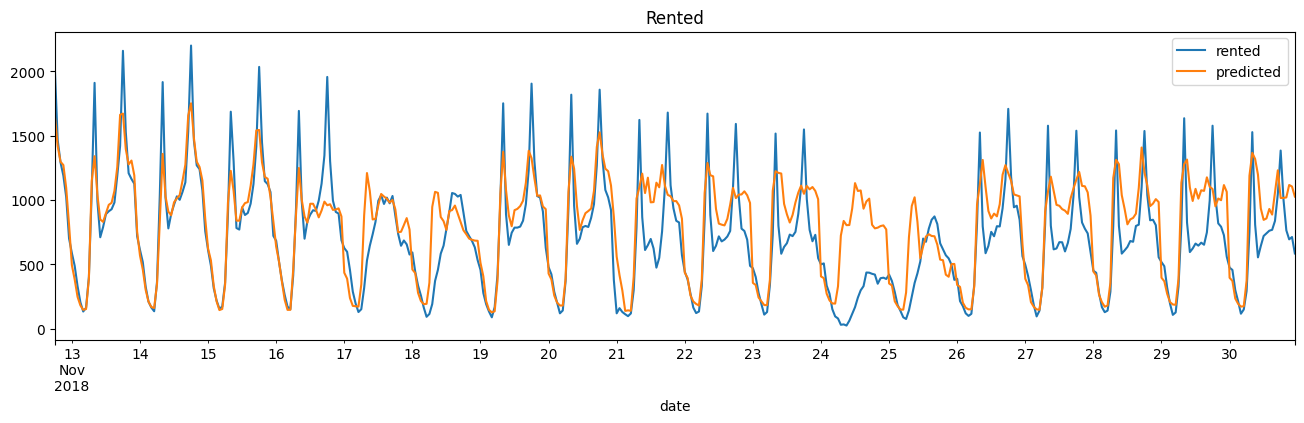

In [8]:
df_test.set_index("date")[
    ["rented", "predicted"]
].plot(
    kind = "line",
    figsize = (16, 4),
    title = "Rented"
)

---
#**Features Importance**
---

<Axes: title={'center': 'Features Importance'}, xlabel='feature'>

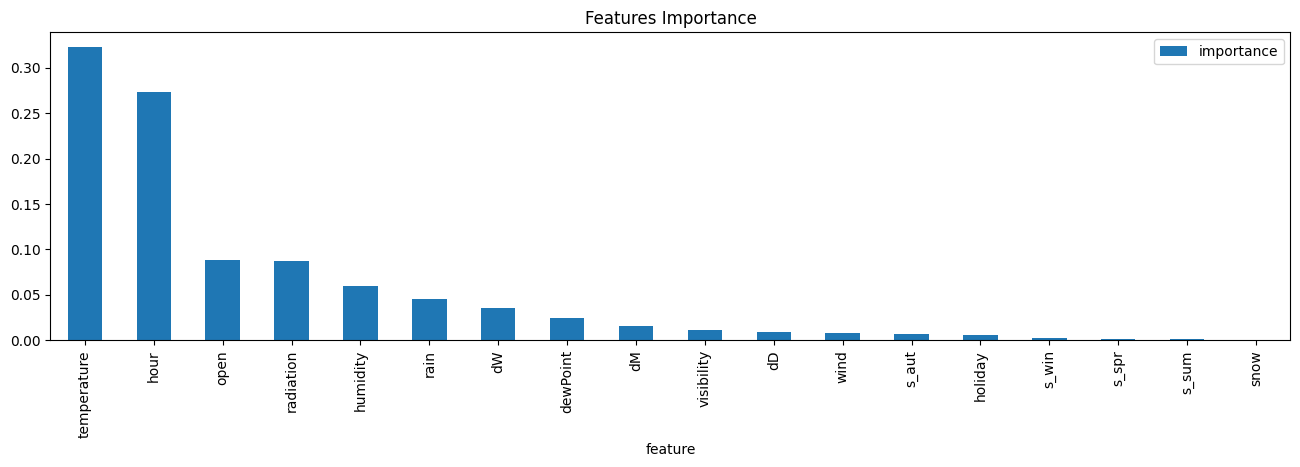

In [25]:
pd.DataFrame(
    {"feature": df_train_x.columns, "importance": model.feature_importances_}
).sort_values(
    by = ["importance"], ascending = False, ignore_index = True
).set_index(
    "feature"
).plot(
    kind = "bar",
    figsize = (16, 4),
    title = "Features Importance"
)

https://docs.profiling.ydata.ai/latest/